## 1.1. Choix du Dataset
- Nom : New York City Taxi Trip Data
- Source : Kaggle → https://www.kaggle.com/datasets/kentonnlp/2014-new-york-city-taxi-trips

#### 📘 Pourquoi ce choix ?
- Ces données sont réelles et de qualité, collectées auprès du NYC Taxi and Limousine Commission.

- La dataset contient des millions de courses avec :

    - Date/heure de prise en charge et dépose

    - Coordonnées GPS

    - Durée et distance du trajet

    - Montant payé

    - Mode de paiement

- Cela est également très représentatif des données de plateformes comme Uber ou Bolt

- Permet de tester plusieurs cas d’usage :

    - Prédiction de prix

    - Optimisation de trajets

    - Analyse spatio-temporelle de la demande

In [4]:
import kagglehub
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
import numpy as np
# Import des bibliothèques ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
import joblib

In [5]:
# Télécharger le jeu de données "2014 New York City Taxi Trips" depuis Kaggle
# et l'enregistrer dans le répertoire de travail actuel.
path = kagglehub.dataset_download("kentonnlp/2014-new-york-city-taxi-trips")

print("Path to dataset files:", path)

Path to dataset files: /home/rouf/.cache/kagglehub/datasets/kentonnlp/2014-new-york-city-taxi-trips/versions/1


In [6]:
# Voir tous les fichiers téléchargés
os.listdir(path)

['nyc_taxi_data_2014.csv.gz', 'nyc_taxi_data_2014.csv']

## ÉTAPE 2 – Nettoyage et Préparation des Données

###  2.1 – Charger un échantillon (500 000 lignes sur plus de 14 000 000 lignes)

In [7]:
# Charger seulement les 100 000 premières lignes pour découvrir la structure
df = pd.read_csv(path + "/nyc_taxi_data_2014.csv", nrows=500_000)

# Aperçu
df.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,CMT,2014-01-09 20:45:25,2014-01-09 20:52:31,1,0.7,-73.994770,40.736828,1,N,-73.982227,40.731790,CRD,6.5,0.5,0.5,1.40,0.0,8.90
1,CMT,2014-01-09 20:46:12,2014-01-09 20:55:12,1,1.4,-73.982392,40.773382,1,N,-73.960449,40.763995,CRD,8.5,0.5,0.5,1.90,0.0,11.40
2,CMT,2014-01-09 20:44:47,2014-01-09 20:59:46,2,2.3,-73.988570,40.739406,1,N,-73.986626,40.765217,CRD,11.5,0.5,0.5,1.50,0.0,14.00
3,CMT,2014-01-09 20:44:57,2014-01-09 20:51:40,1,1.7,-73.960213,40.770464,1,N,-73.979863,40.777050,CRD,7.5,0.5,0.5,1.70,0.0,10.20
4,CMT,2014-01-09 20:47:09,2014-01-09 20:53:32,1,0.9,-73.995371,40.717248,1,N,-73.984367,40.720524,CRD,6.0,0.5,0.5,1.75,0.0,8.75


### 2.2. Vérifier les colonnes et types de données

In [8]:
# Structure des colonnes
df.info()

# Dimensions
print(f"Nombre de lignes : {df.shape[0]}")
print(f"Nombre de colonnes : {df.shape[1]}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   vendor_id           500000 non-null  object 
 1   pickup_datetime     500000 non-null  object 
 2   dropoff_datetime    500000 non-null  object 
 3   passenger_count     500000 non-null  int64  
 4   trip_distance       500000 non-null  float64
 5   pickup_longitude    500000 non-null  float64
 6   pickup_latitude     500000 non-null  float64
 7   rate_code           500000 non-null  int64  
 8   store_and_fwd_flag  499848 non-null  object 
 9   dropoff_longitude   499994 non-null  float64
 10  dropoff_latitude    499994 non-null  float64
 11  payment_type        500000 non-null  object 
 12  fare_amount         500000 non-null  float64
 13  surcharge           500000 non-null  float64
 14  mta_tax             500000 non-null  float64
 15  tip_amount          500000 non-nul

### 2.3 – Conversion des dates

Cela nopus permettra d'extraire facilement :

- L'heure
- Le jour de la semaine
- La durée de trajet

In [9]:
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])
df["dropoff_datetime"] = pd.to_datetime(df["dropoff_datetime"])

### 2.4 – Création de colonnes dérivées utiles
    Ces variables seront très utiles pour explorer les comportements de mobilité et entraîner un modèle.

In [10]:
# Durée du trajet (en minutes)
df["trip_duration_min"] = (df["dropoff_datetime"] - df["pickup_datetime"]).dt.total_seconds() / 60

# Heure de la journée (0 à 23)
df["pickup_hour"] = df["pickup_datetime"].dt.hour

# Jour de la semaine (0 = lundi, 6 = dimanche)
df["pickup_dayofweek"] = df["pickup_datetime"].dt.dayofweek


### 2.5 – Nettoyage des données aberrantes
    On élimine les trajets illogiques ou erronés
    But : éliminer les valeurs aberrantes (valeurs à 0, trop longues ou trop loin pour une course intra-ville).

In [11]:
df = df[df["trip_distance"] > 0]
df = df[df["trip_duration_min"] > 0]
df = df[df["fare_amount"] > 0]
df = df[df["total_amount"] > 0]
df = df[df["trip_duration_min"] < 120]  # Max : 2h
df = df[df["trip_distance"] < 50]       # Max : 50 miles (~80 km)

### 2.6 – Vérification des valeurs manquantes

In [12]:
df.isnull().sum()

vendor_id               0
pickup_datetime         0
dropoff_datetime        0
passenger_count         0
trip_distance           0
pickup_longitude        0
pickup_latitude         0
rate_code               0
store_and_fwd_flag    146
dropoff_longitude       0
dropoff_latitude        0
payment_type            0
fare_amount             0
surcharge               0
mta_tax                 0
tip_amount              0
tolls_amount            0
total_amount            0
trip_duration_min       0
pickup_hour             0
pickup_dayofweek        0
dtype: int64

### 2.7 - store_and_fwd_flag Remplacer les NA par "Unknown"
La colonne tore_and_fwd_flag indique si les données du trajet ont été stockées temporairement dans le taximètre avant d’être transmises au serveur central.
- "N" (No) : Les données ont été envoyées directement en temps réel.
- "Y" (Yes) : Les données ont été stockées puis transmises plus tard (par exemple, si le véhicule était hors connexion).

Cela peut servir à :
- Identifier les trajets où la transmission des données n’a pas été immédiate.
- Analyser la qualité ou la fiabilité des données en fonction du mode de transmission.
- Étudier les zones ou moments où la connexion réseau était absente ou instable.

In [13]:
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].fillna('Unknown')

cela permet de garder la trace des incertitudes dans tes données.

## Étape 3 – Analyse exploratoire des données (EDA)

### 3.1 – Statistiques descriptives générales

In [14]:
# Résumé statistique de toutes les colonnes numériques
df.describe()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,trip_duration_min,pickup_hour,pickup_dayofweek
count,497761,497761,497761.000000,497761.000000,497761.000000,497761.000000,497761.000000,497761.000000,497761.000000,497761.000000,497761.000000,497761.000000,497761.000000,497761.000000,497761.000000,497761.000000,497761.000000,497761.000000
mean,2014-01-10 20:43:01.077320192,2014-01-10 20:55:11.203947776,1.266080,2.926764,-72.723589,40.058135,1.032556,-72.746062,40.071535,12.108875,0.292868,0.498492,2.150723,0.233097,15.284055,12.168777,13.227264,4.288884
min,2014-01-03 14:59:23,2014-01-03 15:19:17,0.000000,0.080000,-83.447762,0.000000,0.000000,-82.232566,0.000000,2.500000,0.000000,0.000000,0.000000,0.000000,3.000000,0.016667,0.000000,0.000000
25%,2014-01-10 09:20:03,2014-01-10 09:35:29,1.000000,1.100000,-73.993268,40.731548,1.000000,-73.992229,40.730298,6.500000,0.000000,0.500000,1.000000,0.000000,8.500000,6.383333,8.000000,4.000000
50%,2014-01-11 02:01:20,2014-01-11 02:12:46,1.000000,1.900000,-73.982951,40.749725,1.000000,-73.981188,40.750222,9.500000,0.000000,0.500000,1.700000,0.000000,11.870000,10.133333,14.000000,5.000000
75%,2014-01-12 00:11:07,2014-01-12 00:23:12,1.000000,3.300000,-73.968351,40.765423,1.000000,-73.964053,40.767019,14.000000,0.500000,0.500000,2.600000,0.000000,17.000000,15.566667,19.000000,6.000000
max,2014-01-20 01:28:00,2014-01-20 01:34:00,9.000000,48.800000,0.000000,47.590428,210.000000,0.000000,48.085159,280.000000,6.000000,0.500000,120.120000,20.000000,299.590000,118.916667,23.000000,6.000000
std,NaN,NaN,0.602015,3.267439,9.546535,5.258614,1.131430,9.458023,5.210051,9.464760,0.326909,0.027415,2.241221,1.161976,11.818200,8.473459,6.985857,1.725509


### 3.2 – Distribution des montants de course (fare_amount)

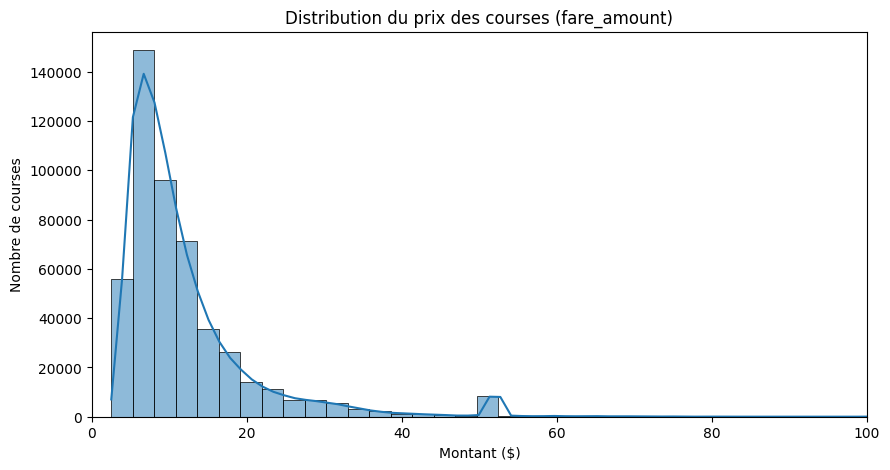

In [15]:
plt.figure(figsize=(10, 5))
sns.histplot(df["fare_amount"], bins=100, kde=True)
plt.title("Distribution du prix des courses (fare_amount)")
plt.xlabel("Montant ($)")
plt.ylabel("Nombre de courses")
plt.xlim(0, 100)
plt.show()

### 3.3 – Distance parcourue vs prix

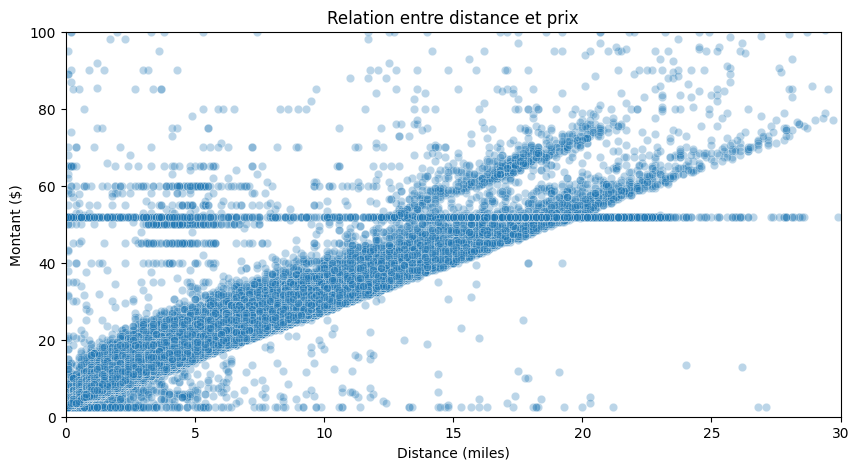

In [16]:
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x="trip_distance", y="fare_amount", alpha=0.3)
plt.title("Relation entre distance et prix")
plt.xlabel("Distance (miles)")
plt.ylabel("Montant ($)")
plt.xlim(0, 30)
plt.ylim(0, 100)
plt.show()

In [17]:
# Prix minimum et maximum par mile (à adapter selon le contexte)
min_price_per_mile = 2
max_price_per_mile = 8

# Filtrage avancé
df_filtre = df[
    (df['trip_distance'] >= 0.5) & (df['trip_distance'] <= 30) &
    (df['fare_amount'] >= 2.5) & (df['fare_amount'] <= 100) &
    (df['fare_amount'] / df['trip_distance'] >= min_price_per_mile) &
    (df['fare_amount'] / df['trip_distance'] <= max_price_per_mile)
]

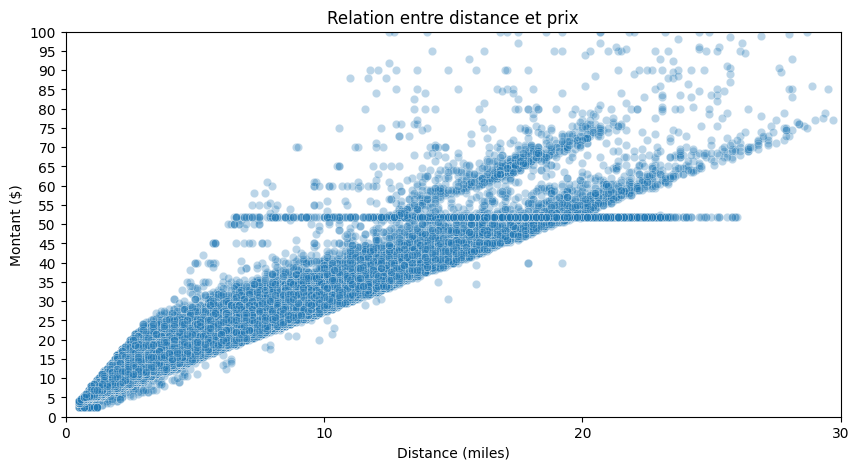

In [18]:
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df_filtre, x="trip_distance", y="fare_amount", alpha=0.3)
plt.title("Relation entre distance et prix")
plt.xlabel("Distance (miles)")
plt.ylabel("Montant ($)")
plt.xlim(0, 30)
plt.ylim(0, 100)
# Définir les ticks de l'axe x (tous les 1 mile)
plt.xticks(range(0, 31, 10))
# Définir les ticks de l'axe y (tous les 10 dollars)
plt.yticks(range(0, 101, 5))
plt.show()

In [19]:
# Afficher les montants les plus fréquents
print(df_filtre['fare_amount'].value_counts())

fare_amount
7.00     23395
7.50     22658
6.50     22499
6.00     22355
8.00     22170
         ...  
52.01        1
74.75        1
94.50        1
92.50        1
99.50        1
Name: count, Length: 203, dtype: int64


In [20]:
# Exemple pour exclure la bande à 52$
df_filtre = df_filtre[df_filtre['fare_amount'] != 52]

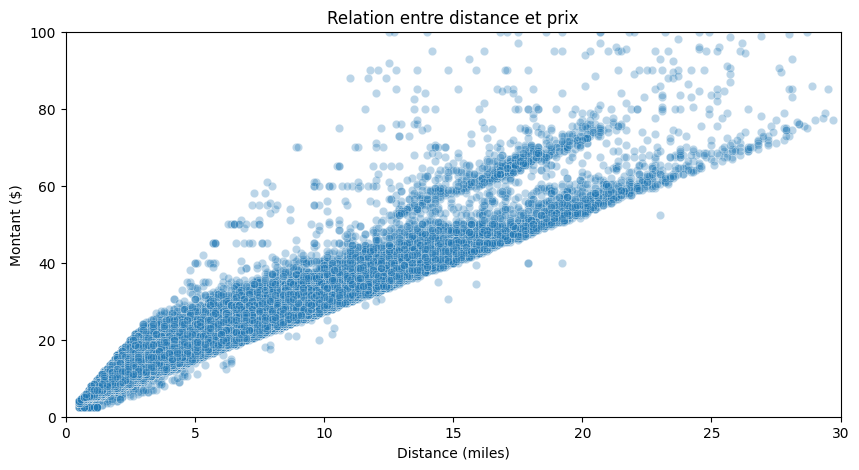

In [21]:
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df_filtre, x="trip_distance", y="fare_amount", alpha=0.3)
plt.title("Relation entre distance et prix")
plt.xlabel("Distance (miles)")
plt.ylabel("Montant ($)")
plt.xlim(0, 30)
plt.ylim(0, 100)
plt.show()

###  3.4 – Nombre de courses par heure de la journée

/tmp/ipykernel_8936/2305497379.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="pickup_hour", data=df_filtre, palette="crest")


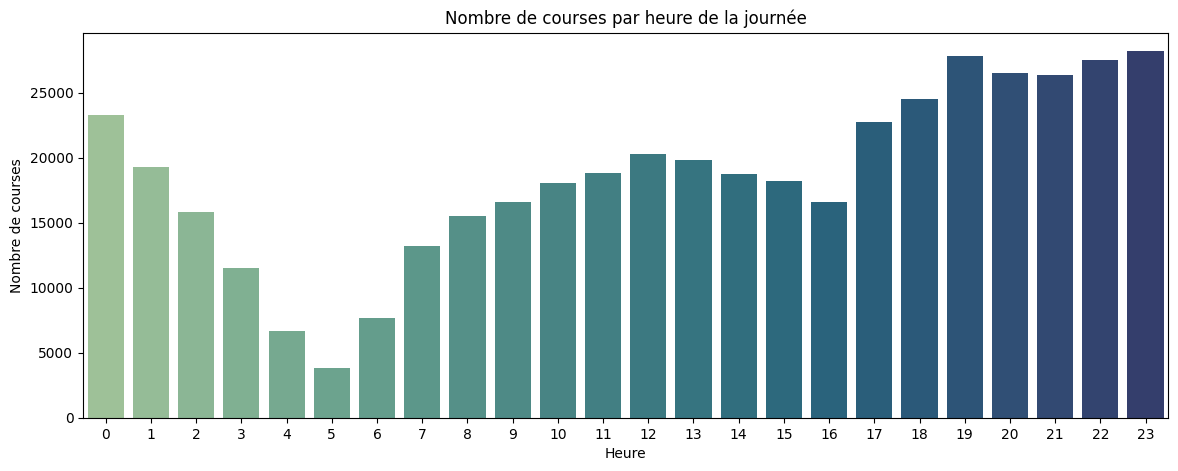

In [22]:
plt.figure(figsize=(14, 5))
sns.countplot(x="pickup_hour", data=df_filtre, palette="crest")
plt.title("Nombre de courses par heure de la journée")
plt.xlabel("Heure")
plt.ylabel("Nombre de courses")
plt.show()

### 3.5 – Nombre de courses par jour de la semaine

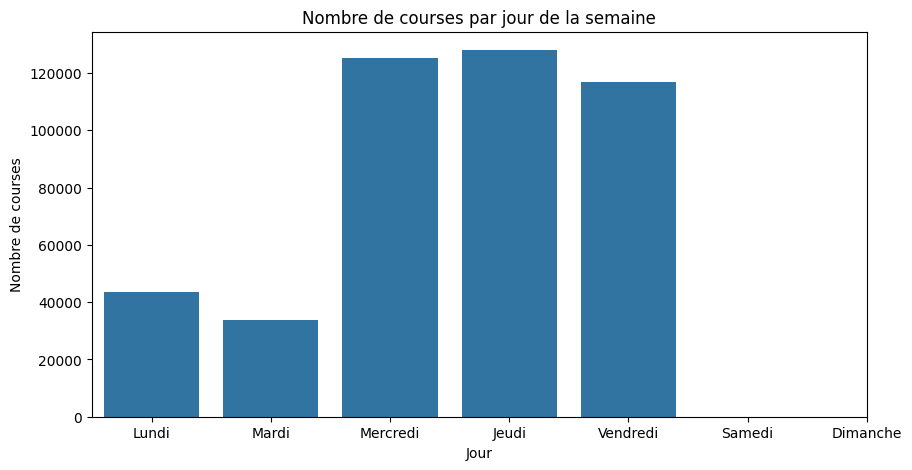

In [23]:
plt.figure(figsize=(10, 5))
days = ["Lundi", "Mardi", "Mercredi", "Jeudi", "Vendredi", "Samedi", "Dimanche"]
sns.countplot(x="pickup_dayofweek", data=df_filtre)
plt.title("Nombre de courses par jour de la semaine")
plt.xlabel("Jour")
plt.ylabel("Nombre de courses")
plt.xticks(ticks=range(7), labels=days)
plt.show()

### 3.6 – Répartition des types de paiement

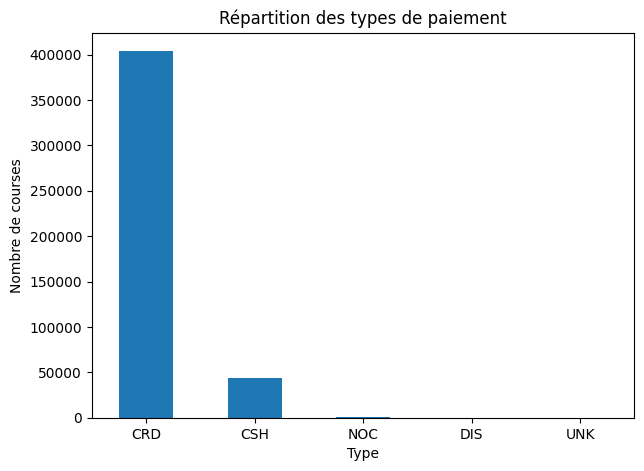

In [24]:
plt.figure(figsize=(7, 5))
df_filtre["payment_type"].value_counts().plot(kind="bar")
plt.title("Répartition des types de paiement")
plt.xlabel("Type")
plt.ylabel("Nombre de courses")
plt.xticks(rotation=0)
plt.show()

### 3.7 – Corrélation entre variables numériques

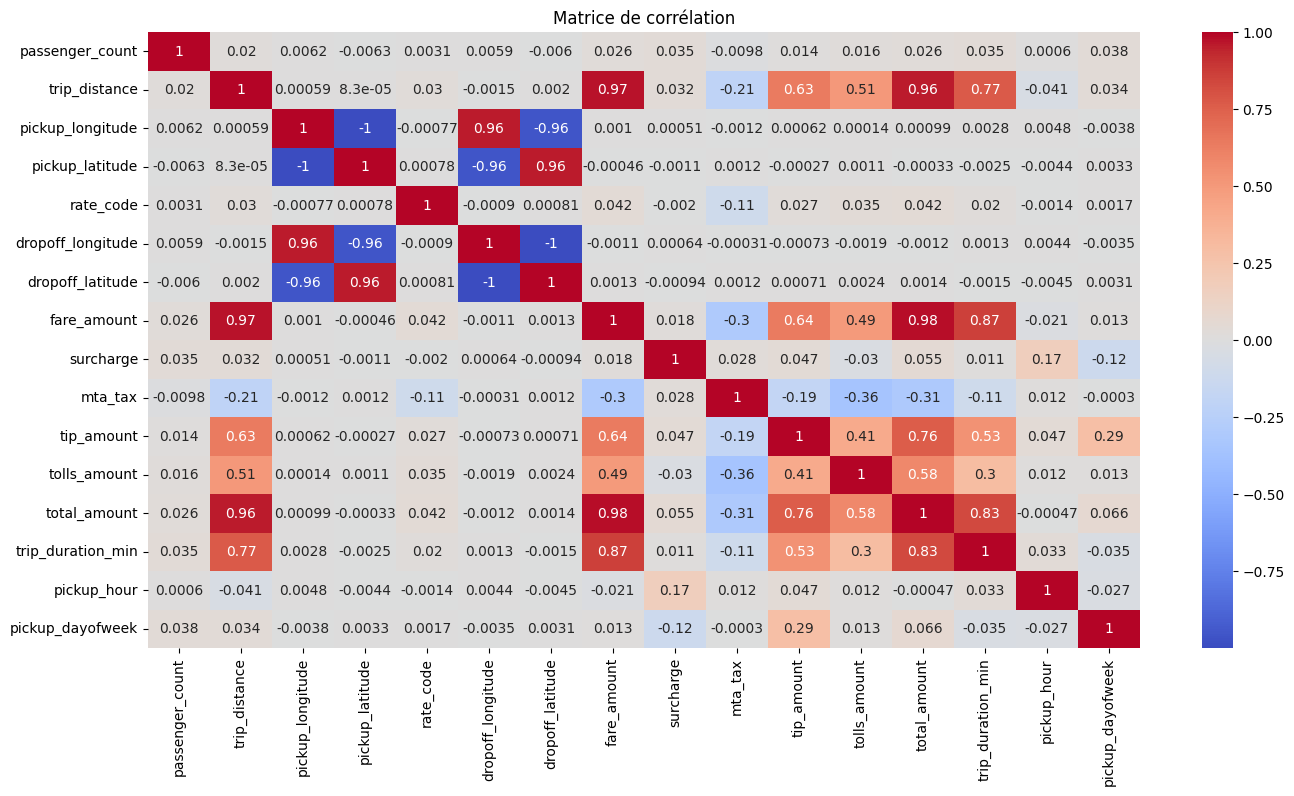

In [25]:
plt.figure(figsize=(16, 8))
sns.heatmap(df_filtre.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Matrice de corrélation")
plt.show()

## ÉTAPE 4 BIS – VISUALISATION GÉOGRAPHIQUE DES COURSES

### 4.1 – Filtrer les données géographiques

In [26]:
# Pour alléger le rendu, on prend un échantillon de 10 000 points
df_geo = df_filtre[['pickup_latitude', 'pickup_longitude']].dropna()
df_geo = df_geo[(df_geo['pickup_latitude'] != 0) & (df_geo['pickup_longitude'] != 0)]
df_sample = df_geo.sample(n=10000, random_state=42)

### 4.2 – Créer une carte centrée sur New York

In [27]:
# Coordonnées approximatives du centre de NYC
nyc_center = [40.730610, -73.935242]

# Créer la carte
m = folium.Map(location=nyc_center, zoom_start=11)

### 4.3 – Ajouter une HeatMap des points de départ

In [28]:
# Convertir en liste de points
heat_data = [[row['pickup_latitude'], row['pickup_longitude']] for index, row in df_sample.iterrows()]

# Ajouter la couche HeatMap
HeatMap(heat_data, radius=7, blur=4).add_to(m)

# Afficher la carte
m

### 4.4 – Variante : visualiser les trajets (pickup → dropoff)

In [29]:
df_routes = df_filtre[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']].dropna()
df_routes = df_routes.sample(n=500, random_state=1)

# Nouvelle carte
map_routes = folium.Map(location=nyc_center, zoom_start=12)

# Tracer chaque ligne de trajet
for _, row in df_routes.iterrows():
    folium.PolyLine(
        locations=[(row['pickup_latitude'], row['pickup_longitude']),
                   (row['dropoff_latitude'], row['dropoff_longitude'])],
        color='green',
        weight=1,
        opacity=0.5
    ).add_to(map_routes)

map_routes


## ÉTAPE 5 – MODÉLISATION (ML) : PRÉDICTION DU PRIX D’UNE COURSE

Objectif :
Entraîner un modèle de régression pour prédire fare_amount en fonction de :

trip_distance

trip_duration_min

pickup_hour

pickup_dayofweek

passenger_count

et autres variables utiles

### 5.1 – Sélection des features et target

In [30]:
# Variables explicatives (features)
features = [
    "trip_distance",
    "trip_duration_min",
    "pickup_hour",
    "pickup_dayofweek",
    "passenger_count"
]

X = df_filtre[features]
y = df_filtre["fare_amount"]


### 5.2 – Séparer les données en train/test

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### 5.3 – Entraîner un modèle de régression linéaire

In [32]:
lr = LinearRegression()
lr.fit(X_train, y_train)

# Prédictions
y_pred_lr = lr.predict(X_test)

### 5.4 – Évaluer les performances

In [33]:


def eval_model(y_true, y_pred):
    print("MAE :", round(mean_absolute_error(y_true, y_pred), 2))
    print("RMSE:", round(np.sqrt(mean_squared_error(y_true, y_pred)), 2))
    print("R²  :", round(r2_score(y_true, y_pred), 2))

print("Régression Linéaire :")
eval_model(y_test, y_pred_lr)

Régression Linéaire :
MAE : 0.43
RMSE: 1.21
R²  : 0.98


### 5.5 – Entraîner un Random Forest (modèle plus puissant)

In [34]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("Random Forest :")
eval_model(y_test, y_pred_rf)

Random Forest :
MAE : 0.35
RMSE: 1.08
R²  : 0.98


### 5.6 – Visualiser les performances

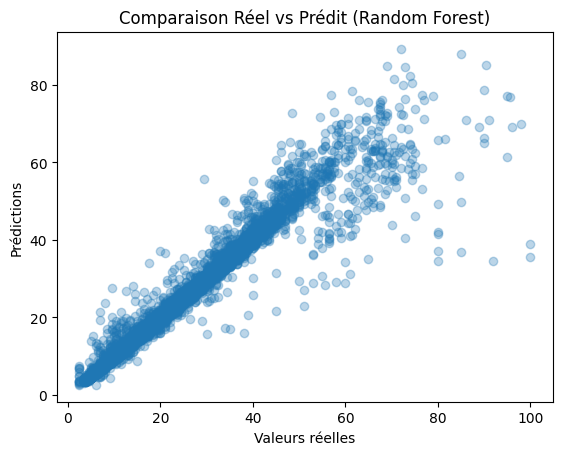

In [35]:
plt.scatter(y_test, y_pred_rf, alpha=0.3)
plt.xlabel("Valeurs réelles")
plt.ylabel("Prédictions")
plt.title("Comparaison Réel vs Prédit (Random Forest)")
plt.show()

## ÉTAPE 6 – ÉVALUATION DU MODÈLE

### Objectif :
- Comparer les performances des modèles (régression linéaire vs Random Forest)

- Interpréter les résultats avec des métriques

- Identifier les variables les plus importantes dans la prédiction

### 6.1 – Évaluation des modèles (résumé)

In [36]:
print("Régression Linéaire :")
eval_model(y_test, y_pred_lr)

print("Random Forest :")
eval_model(y_test, y_pred_rf)


Régression Linéaire :
MAE : 0.43
RMSE: 1.21
R²  : 0.98
Random Forest :
MAE : 0.35
RMSE: 1.08
R²  : 0.98


### 6.2 – Interprétation des erreurs

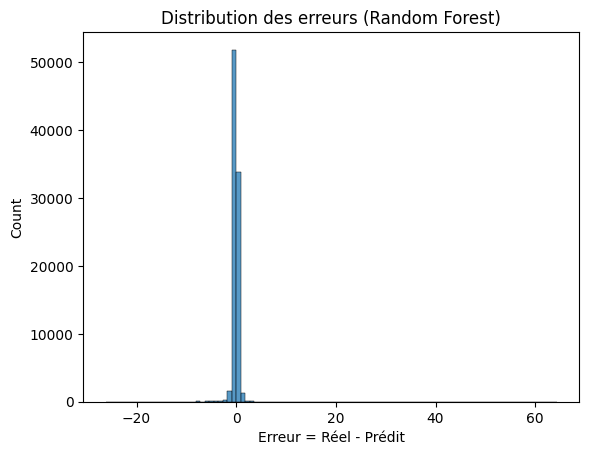

In [37]:
# Histogramme des erreurs
errors = y_test - y_pred_rf

import seaborn as sns
sns.histplot(errors, bins=100)
plt.title("Distribution des erreurs (Random Forest)")
plt.xlabel("Erreur = Réel - Prédit")
plt.show()

### 6.3 – Importance des variables

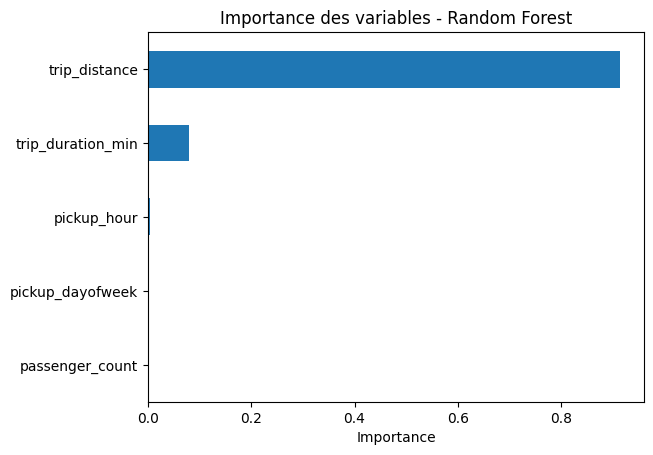

In [38]:
importances = rf.feature_importances_
feature_importance = pd.Series(importances, index=features).sort_values(ascending=True)

# Affichage
feature_importance.plot(kind='barh')
plt.title("Importance des variables - Random Forest")
plt.xlabel("Importance")
plt.show()

### 6.5 – Validation croisée

In [39]:
scores = cross_val_score(rf, X, y, cv=5, scoring='neg_mean_absolute_error')
print("MAE moyen avec validation croisée :", -scores.mean())

MAE moyen avec validation croisée : 0.3594412582148337


## ÉTAPE 7 – DÉPLOIEMENT INTERACTIF AVEC STREAMLIT

### 7.1 – Sauvegarde du modèle Random Forest

In [40]:
joblib.dump(rf, "random_forest_model.pkl")

['random_forest_model.pkl']

### 7.2 – Lancer l’application localement

Dans le terminal :
- streamlit run dashboard_app.py